#Classfication on Tensorflow 

## Introduction

**TensorFlow Lite**

This notebooks shows training a TensorFlow Lite models and testing it by using your own datasets.

For more details, take a look at blog posts:


* [Testing TensorFlow Lite image classification mode](https://thinkmobile.dev/testing-tensorflow-lite-image-classification-model/)l - converting TensorFlow to TensorFlow Lite and comparing models side by side.
Automate testing of TensorFlow Lite model implementation.

* [Automate testing of TensorFlow Lite model implementation](https://thinkmobile.dev/automate-testing-of-tensorflow-lite-model-implementation/) - Testing TensorFlow Lite model on Android app with Espresso and instrumented tests.
 



This notebooks shows some ways for debugging TensorFlow Lite models and comparing them with the original implementations in TensorFlow.


**TensorFlow 2.0 alpha and Colaboratory**

Examples presented in this notebook are built on top of TensorFlow 2.0 beta version. As long as it's not a stable version yet, there is no guarantee that anything here will work as it should.

This notebook was created only for the Colaboratory environment. It requires some changes to make it working on Docker environment described in linked blog post.

GPU support
The good thing about Colab is that it supports GPU envinronment without additional work. Just open Runtime -> Change runtime type and make sure that GPU is selected. The training process of this notebook should be about 3 times faster than on CPU env.

## **Install requirements**


In [0]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

     |████████████████████████████████| 348.9MB 48kB/s 
     |████████████████████████████████| 501kB 35.8MB/s 
     |████████████████████████████████| 3.1MB 48.1MB/s 


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

For better data visualization we'll use Pandas library.

In [0]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

Verify system

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.15.0
Hub version:  0.7.0
Eager mode:  False
GPU is available


## **Prepare dataset**

Connect your drive with your gmail

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Set your training folder which contains images


In [0]:
data_root='/content/drive/My Drive/cancerdataset';

Create data generator for training and validation

In [2]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/drive/My Drive/cancerdataset


NameError: ignored

Learn more about data batches

In [0]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Benign' 'Malignant']


# Training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. Presented model can be used only in TensorFlow 2.0 implementation (TF Hub contains also models for TensorFlow 1.x).
Basic information about feature vector:


*   Input shape: 224x224x3 (224x224 pixels, 3 chanels each, RGB format),
*   Each channel has value in range [0, 1],
*   Feature vector output shape: 1280 (number of labels classified by MobileNet is 1001 - this info isn't important here)

For more details check feature vector page: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4




In [0]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

*Lets Train Our model!*

In [0]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


5/5 [==============================] - 58s 12s/step - loss: 0.8950 - acc: 0.6029 - val_loss: 0.7047 - val_acc: 0.6111
Epoch 2/10
5/5 [==============================] - 1s 102ms/step - loss: 0.9214 - acc: 0.5777 - val_loss: 0.5834 - val_acc: 0.7222
Epoch 3/10
5/5 [==============================] - 1s 112ms/step - loss: 0.8712 - acc: 0.5358 - val_loss: 0.5846 - val_acc: 0.6944
Epoch 4/10
5/5 [==============================] - 1s 122ms/step - loss: 0.6926 - acc: 0.6382 - val_loss: 0.6471 - val_acc: 0.5556
Epoch 5/10
5/5 [==============================] - 1s 108ms/step - loss: 0.6762 - acc: 0.6219 - val_loss: 0.6935 - val_acc: 0.5278
Epoch 6/10
5/5 [==============================] - 1s 126ms/step - loss: 0.6605 - acc: 0.6775 - val_loss: 0.6478 - val_acc: 0.5833
Epoch 7/10
5/5 [==============================] - 1s 122ms/step - loss: 0.5912 - acc: 0.7849 - val_loss: 0.6088 - val_acc: 0.6389
Epoch 8/10
5/5 [==============================] - 1s 126ms/step - loss: 0.5537 - acc: 0.6607 - val_los

Measure accuracy and loss after training

In [0]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 0s 63ms/step - loss: 0.4787 - acc: 0.7500
Final loss: 0.48
Final accuracy: 75.00%


# Exporting Model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.

In [0]:
SHOE_SAVED_MODEL = "saved_models/shoe"
tf.keras.experimental.export_saved_model(model, SHOE_SAVED_MODEL)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.
Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f08c99ddfd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f08c5a170b8>,)


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: saved_models/shoe/saved_model.pb


INFO:tensorflow:SavedModel written to: saved_models/shoe/saved_model.pb


## Load TensorFlow SavedModel
Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with custom_obiects param.

In [0]:
# Load SavedModel

shoe_model = tf.keras.experimental.load_from_saved_model(SHOE_SAVED_MODEL, 
                                                            custom_objects={'KerasLayer':hub.KerasLayer})

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f08c49a2f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f08c269e240>,)


## Check predictions on loaded model

In [0]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


Validation batch shape tells us that we have a batch of 32 images, with size and channels: 224x224x3.

Let's calculate predictions for the entire batch.

In [0]:
tf_model_predictions = shoe_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


Convert prediction results to Pandas dataframe, for better visualization

In [0]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Benign,Malignant
0,0.14654969,0.85345036
1,0.42017624,0.57982379
2,0.42352137,0.57647860
3,0.65408379,0.34591624
4,0.66977990,0.33022010


In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

Print images batch and labels predictions

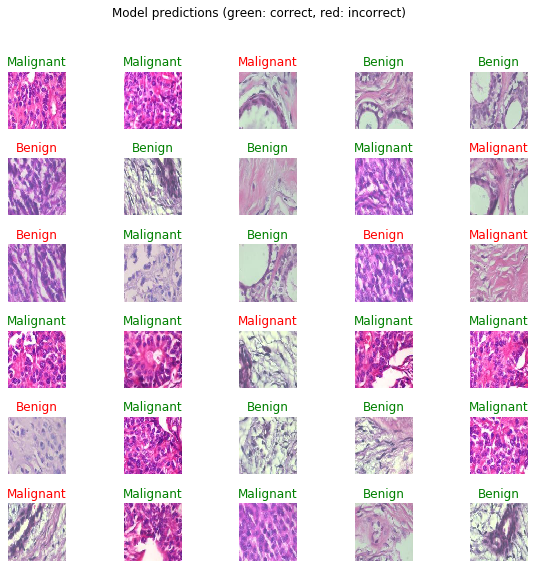

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a post-training quantization).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite. 

In [0]:
!mkdir "tflite_models"

In [0]:
TFLITE_MODEL = "tflite_models/cancer.tflite"
TFLITE_QUANT_MODEL = "tflite_models/cancer_quant.tflite"

In [0]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : shoe_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


TFLite models and their sizes:
total 22M
-rw-r--r-- 1 root root 2.3M Mar  7 05:30 cancer_quant.tflite
-rw-r--r-- 1 root root 8.5M Mar  7 05:30 cancer.tflite
-rw-r--r-- 1 root root 2.3M Mar  7 05:15 shoe_quant.tflite
-rw-r--r-- 1 root root 8.5M Mar  7 05:15 shoe.tflite


It is over. Now, you can download it :)